## Generate Background Notebook

This notebook generates background images that can be feed to galaxycluster.py 
@marcoc7, last edited 1/28/2025

In [2]:
#import relevant libaries
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import astropy
from astropy.table import Table
from astropy.io import fits

%load_ext autoreload


import sys
from pathlib import Path

base_dir = Path.cwd()
autolens_config_path = base_dir / "autolens_config"
spherex_path = base_dir / "SPHEREx"

sys.path.append(str(autolens_config_path))
sys.path.append(str(spherex_path))


#import gcluster15  # from autolens_config
import SPHERExScripts as SPHEREx  # from SPHEREX
import autolens_config


In [3]:
%autoreload 2

### Part 1: Creating a relevant data set for this project

Open merged catalog (filtered for galaxies only), filter for relevant redshift ranges, output new table


In [3]:
#Open merged table (@ James, this file is only accessible on Rabbit!)
#cat = Table.read('/home/marco/fits_files/processed_master_v6-1.fits')
cat = Table.read('/home/marco/lsHEROESmergedv2') #This table should appear in both computers? Maybe not, I will check it later shrug

#/home/marco/lsHEROESmergedv2.fits

In [4]:
cat
#23,482,097 objects in filtered table, should all be galaxies

ra_heroes,dec_heroes,ra_ls,dec_ls,from,ls_id,hsc_id,type,i_ap2,i_ap2err,i_kron,i_kronerr,z_ap2,z_ap2err,z_kron,z_kronerr,flux_z,mag_z,snr_z,y_ap2,y_ap2err,y_kron,y_kronerr,n816_ap2,n816_ap2err,n816_kron,n816_kronerr,n921_ap2,n921_ap2err,n921_kron,n921_kronerr,mag_w1,flux_w1,snr_w1,mag_w2,flux_w2,snr_w2,mag_w3,flux_w3,snr_w3,mag_w4,flux_w4,snr_w4,x,y,xx,yy,xy,patch,wise_coadd_id,brickid,brickname,sersic,shape_r,shape_e1,shape_e2,ellipticity,theta,sc_id
float64,float64,float64,float64,bytes6,int64,int64,bytes3,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,bytes5,bytes8,int64,bytes8,float64,float64,float64,float64,float64,float64,int64
278.53500138043825,63.9749665047913,--,--,HEROES,--,158913789953,--,--,--,--,--,23.559645,0.21461079,--,--,--,--,--,-23.850363,0.7138585,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,19949.146,59448.258,--,--,--,"1,5",--,--,--,--,--,--,--,--,--,--
278.54114302999335,63.97458600247457,--,--,HEROES,--,158913789954,--,--,--,--,--,24.353443,0.44712862,23.963285,0.24130464,--,--,--,23.672665,0.61583346,25.028233,1.6664253,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,19890.473,59448.87,3.136412,3.7544372,1.5408987,"1,5",--,--,--,--,--,--,--,--,--,--
278.53467936808585,63.98020507322936,--,--,HEROES,--,158913789960,--,--,--,--,--,23.596027,0.21847671,23.608713,0.2265859,--,--,--,23.064314,0.2341843,23.138815,0.26028684,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,19969.445,59559.27,2.9423282,7.981417,-2.4735303,"1,5",--,--,--,--,--,--,--,--,--,--
278.54366208675265,63.979596966488785,--,--,HEROES,--,158913789961,--,--,--,--,--,24.422678,0.47287714,24.341719,0.3389037,--,--,--,23.07018,0.34841648,23.06124,0.26967525,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,19883.473,59559.066,3.3169792,1.5757403,-0.9627106,"1,5",--,--,--,--,--,--,--,--,--,--
278.557056527257,63.98110038446475,--,--,HEROES,--,158913789966,--,--,--,--,--,23.784037,0.2651253,23.840254,0.2155417,--,--,--,23.326906,0.4468022,23.219593,0.31476638,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,19763.244,59610.066,3.554889,4.4261637,-2.4642541,"1,5",--,--,--,--,--,--,--,--,--,--
278.5660856348791,63.98054121651192,--,--,HEROES,--,158913789967,--,--,--,--,--,--,--,--,--,--,--,--,21.020847,0.05430802,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,19677.0,59611.0,--,--,--,"1,5",--,--,--,--,--,--,--,--,--,--
278.5422704450695,63.982163849010426,--,--,HEROES,--,158913789968,--,--,--,--,--,23.621317,0.22423156,--,--,--,--,--,23.831797,0.47693807,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,19904.959,59611.71,--,--,--,"1,5",--,--,--,--,--,--,--,--,--,--
278.562633433481,63.982529692938314,--,--,HEROES,--,158913789971,--,--,--,--,--,23.6037,0.22494477,23.531757,0.20944446,--,--,--,23.072655,0.35450727,23.254608,0.41856563,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,19715.848,59648.402,1.097193,3.530041,1.078596,"1,5",--,--,--,--,--,--,--,--,--,--
278.5502414378729,63.98346593960416,--,--,HEROES,--,158913789972,--,--,--,--,--,23.061796,0.13471395,23.24774,0.22281943,--,--,--,23.019363,0.33279997,22.713615,0.35374734,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,19834.762,59650.727,3.682224,6.6021667,1.3244936,"1,5",--,--,--,--,--,--,--,--,--,--


In [5]:
print(cat.colnames)


['ra_heroes', 'dec_heroes', 'ra_ls', 'dec_ls', 'from', 'ls_id', 'hsc_id', 'type', 'i_ap2', 'i_ap2err', 'i_kron', 'i_kronerr', 'z_ap2', 'z_ap2err', 'z_kron', 'z_kronerr', 'flux_z', 'mag_z', 'snr_z', 'y_ap2', 'y_ap2err', 'y_kron', 'y_kronerr', 'n816_ap2', 'n816_ap2err', 'n816_kron', 'n816_kronerr', 'n921_ap2', 'n921_ap2err', 'n921_kron', 'n921_kronerr', 'mag_w1', 'flux_w1', 'snr_w1', 'mag_w2', 'flux_w2', 'snr_w2', 'mag_w3', 'flux_w3', 'snr_w3', 'mag_w4', 'flux_w4', 'snr_w4', 'x', 'y', 'xx', 'yy', 'xy', 'patch', 'wise_coadd_id', 'brickid', 'brickname', 'sersic', 'shape_r', 'shape_e1', 'shape_e2', 'ellipticity', 'theta', 'sc_id']


In [4]:
#Filtering out stuff: 

tab = cat
#Filters out irrelevant data, masks invalid data, and creates a newTable, called cTable to use for the data processing later in this notebook (saves time)

#Masks out stuff
tab['z_ap2err'] = np.ma.masked_invalid(tab['z_ap2err'])
tab['z_ap2'] = np.ma.masked_invalid(tab['z_ap2'])
tab['snr_z'] = np.ma.masked_invalid(tab['snr_z'])
tab['mag_z'] = np.ma.masked_invalid(tab['mag_z'])

# Define filter conditions
condition1 = (1/tab['z_ap2err'] > 5) & (tab['z_ap2'] > 0) # SUBARU specific filter
condition2 = (tab['snr_z'] > 5) & (tab['mag_z'] > 0) # DESI specific filter

# Handle masked values to ensure they are considered invalid in the conditions
condition1 = condition1.filled(False)
condition2 = condition2.filled(False)

# Combine conditions based on the specified requirements
final_condition = (
    (condition1 & np.ma.getmaskarray(tab['snr_z']) & np.ma.getmaskarray(tab['mag_z'])) |  # Condition 1 valid, Condition 2 invalid
    (condition2 & np.ma.getmaskarray(tab['z_ap2err']) & np.ma.getmaskarray(tab['z_ap2'])) |  # Condition 2 valid, Condition 1 invalid
    (condition1 & condition2)  # Both conditions valid and both pass
)

tab = tab[final_condition]


tab['z_ap2_flux'] = 10**((22.5 - tab['z_ap2']) / 2.5) #Converts AB Mag to nMJy
tab['snr_z_ap2'] = 1/tab['z_ap2err'] #SNR of HEROES Data


#Just a random function I made to create a new data table
def combined_column(tab,new_tab,col1_name, col2_name, combined_col_name):
    '''
    NOTE: IF BOTH COLUMNS HAVE VALID DATA, THEN COLUMN 1 VALUES WILL BE USED!!
    '''
    tab[col1_name] = np.ma.masked_invalid(tab[col1_name])
    tab[col2_name] = np.ma.masked_invalid(tab[col2_name])
        
    new_tab[combined_col_name] = np.where(tab[col1_name].mask, tab[col2_name], tab[col1_name])
    
cTab = Table()

combined_column(tab,cTab,'snr_z','snr_z_ap2','snr_z')
combined_column(tab,cTab,'flux_z','z_ap2_flux','flux_z')

combined_column(tab,cTab,'ra_heroes','ra_ls','ra')
combined_column(tab,cTab,'dec_heroes','dec_ls','dec')
cTab['from'] = tab['from']
cTab['sersic'] = tab['sersic']
cTab['shape_r'] = tab['shape_r']
cTab['ellipticity'] = tab['ellipticity']
cTab['theta'] = tab['theta']
cTab['type'] = tab['type']
cTab['z_ap2'] = tab['z_ap2']
cTab['mag_z'] = tab['mag_z']


print('Compressed Data Table (cTab) HAS BEEN CREATED') 
#Note: There needs to be a better version of this, as if I have to cycle through different bands....(ask Thomas about the photometry table format!)

Compressed Data Table (cTab) HAS BEEN CREATED


In [7]:
cTab

snr_z,flux_z,ra,dec,from,sersic,shape_r,ellipticity,theta,type,z_ap2,mag_z
float64,float64,float64,float64,bytes6,float64,float64,float64,float64,bytes3,float32,float64
7.423136234283447,0.5960483551025391,278.5502414378729,63.98346593960416,HEROES,--,--,--,--,--,23.061796,--
5.824462890625,0.47450974583625793,278.56635461594584,63.98386263607685,HEROES,--,--,--,--,--,23.309387,--
8.229771614074707,0.6526135206222534,278.54468232557014,63.98780203243494,HEROES,--,--,--,--,--,22.96336,--
6.142543315887451,0.4910074770450592,278.5616275588034,63.98965381349078,HEROES,--,--,--,--,--,23.27228,--
7.586978435516357,0.5949039459228516,278.5392191956687,63.991583319762334,HEROES,--,--,--,--,--,23.063883,--
5.520657062530518,0.4495585560798645,278.5824439301725,63.9909842405763,HEROES,--,--,--,--,--,23.368034,--
5.631864547729492,0.4526507556438446,278.57189930902774,63.99198912231289,HEROES,--,--,--,--,--,23.360592,--
6.566609859466553,0.5200942158699036,278.56373989241666,63.99558895428802,HEROES,--,--,--,--,--,23.209795,--
6.589621067047119,0.5362299084663391,278.5912509403485,63.995284997680685,HEROES,--,--,--,--,--,23.176622,--


In [5]:
cTab.write('/home/marco/SPHEREx-ML/largeOutputs/zFluxTableFiltered.fits',format = 'fits',overwrite=True) 
#/home/marco/SPHEREx-ML/largeOutputs/zFluxTableFiltered.fits
#^This is the compressed table that will be used for the data processing later on in this notebook

#### Actually Make The Image

In [4]:
catalog = Table.read('/home/marco/SPHEREx-ML/largeOutputs/zFluxTableFiltered.fits',format = 'fits')
catalog

snr_z,flux_z,ra,dec,from,sersic,shape_r,ellipticity,theta,type,z_ap2,mag_z
float64,float64,float64,float64,bytes6,float64,float64,float64,float64,bytes3,float32,float64
7.423136234283447,0.5960483551025391,278.5502414378729,63.98346593960416,HEROES,--,--,--,--,--,23.061796,--
5.824462890625,0.47450974583625793,278.56635461594584,63.98386263607685,HEROES,--,--,--,--,--,23.309387,--
8.229771614074707,0.6526135206222534,278.54468232557014,63.98780203243494,HEROES,--,--,--,--,--,22.96336,--
6.142543315887451,0.4910074770450592,278.5616275588034,63.98965381349078,HEROES,--,--,--,--,--,23.27228,--
7.586978435516357,0.5949039459228516,278.5392191956687,63.991583319762334,HEROES,--,--,--,--,--,23.063883,--
5.520657062530518,0.4495585560798645,278.5824439301725,63.9909842405763,HEROES,--,--,--,--,--,23.368034,--
5.631864547729492,0.4526507556438446,278.57189930902774,63.99198912231289,HEROES,--,--,--,--,--,23.360592,--
6.566609859466553,0.5200942158699036,278.56373989241666,63.99558895428802,HEROES,--,--,--,--,--,23.209795,--
6.589621067047119,0.5362299084663391,278.5912509403485,63.995284997680685,HEROES,--,--,--,--,--,23.176622,--


In [ ]:
#Since we want these images in 683, 683 original image size... 
#We will now uses Marco's SPHEREx Scripts to do stuff: 


In [5]:
#Load PSF Data: 
psf,reso_ratio,psf_length = SPHEREx.loadPSFData(filePath = '/home/marco/SPHEREx-ML/SPHEREx-ML-marco-jame-proj/SPHEREx/psf_data/simulated_PSF_2DGaussian_1perarray.fits',
                                               )

In [6]:
def loadPSFData(filePath = '/home/marco/SPHEREx-ML/SPHEREx-ML-marco-jame-proj/SPHEREx/psf_data/simulated_PSF_2DGaussian_1perarray.fits',target_resolution = 6.2):
    hdul =fits.open(filePath)
    hdu_psf = hdul[42]
    print(target_resolution)
    reso_ratio = int(target_resolution/hdu_psf.header['HIERARCH platescale'])

    # Crop PSF image to 98x98 pixels, then normalize the PSF so sum of all pixel = 1
    psf = hdu_psf.data
    c = int(psf.shape[0]/2)
    psf_length = 54 #49? Was told to keep it at 54
    psf = psf[c-psf_length:c+psf_length, c-psf_length:c+psf_length]
    psf = psf/np.sum(psf)
    return psf,reso_ratio,psf_length

psf,reso_ratio,psf_length = loadPSFData(filePath = '/home/marco/SPHEREx-ML/SPHEREx-ML-marco-jame-proj/SPHEREx/psf_data/simulated_PSF_2DGaussian_1perarray.fits')


6.2


In [7]:
reso_ratio

18

In [7]:
import astropy
from astropy.io import fits

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import binned_statistic_2d
from scipy.ndimage import convolve
from scipy.signal import correlate

import matplotlib as mpl


from scipy.signal import correlate
from astropy.io import fits


from astropy.modeling.models import Sersic2D
from scipy.integrate import dblquad
from astropy.coordinates.matrix_utilities import rotation_matrix
from astropy.coordinates import SkyCoord
from astropy import units as u
from scipy.stats import binned_statistic_2d
from tqdm import tqdm





#Function for Loading in SPHEREx PSF Data: 
def loadPSFData(filePath = 'SPHEREx\psf_data\simulated_PSF_2DGaussian_1perarray.fits'):
    hdul =fits.open(filePath)
    hdu_psf = hdul[42]
    reso_ratio = int(3.1/hdu_psf.header['HIERARCH platescale'])

    # Crop PSF image to 98x98 pixels, then normalize the PSF so sum of all pixel = 1
    psf = hdu_psf.data
    c = int(psf.shape[0]/2)
    psf_length = 54 #49? Was told to keep it at 54
    psf = psf[c-psf_length:c+psf_length, c-psf_length:c+psf_length]
    psf = psf/np.sum(psf)
    return psf,reso_ratio,psf_length



def add_sersic_to_canvas(canvas, x, y, flux, n=4, r_eff=10, ellip=0.5, theta=0, x_grid=None, y_grid=None): 

    """
    Add a Sersic profile to the canvas with the specified total flux.

    Parameters:
    canvas (2D array): The image canvas to draw on.
    x, y (int): The central position of the Sersic profile.
    flux (float): The total flux of the source.
    n (float): The Sersic index.
    r_eff (float): The effective radius of the Sersic profile.
    ellip (float): The ellipticity of the profile (0 is circular).
    theta (float): The position angle of the profile.
    x_grid, y_grid (2D arrays): Predefined grids for x and y coordinates (optional).
    """

    x_grid, y_grid = np.mgrid[:canvas.shape[0], :canvas.shape[1]] 

    # Create an initial Sersic2D model with amplitude 1 
    initial_sersic = Sersic2D(amplitude=1, r_eff=r_eff, n=n, ellip=ellip, theta=theta)
    
    # Shift the grid to center the Sersic profile at (x, y)
    x_grid_shifted = x_grid - x
    y_grid_shifted = y_grid - y
    
    # Evaluate the initial Sersic model on the shifted grid
    initial_profile = initial_sersic(x_grid_shifted, y_grid_shifted)
    
    # Scale the amplitude to match the desired total flux
    amplitude = flux / np.sum(initial_profile)
    
    # Create a Sersic2D model with the scaled amplitude 
    sersic = amplitude * initial_profile
    
    # Evaluate the Sersic model on the shifted grid and add to the canvas
    canvas += sersic

#Generate BackGround Image

from multiprocessing import Pool, cpu_count
from multiprocessing import Manager
import time
#V6: Removes most of the metadata generation, also hard codes it such that each image is of SPHEREx Pix = 2061 (3.1779 sq degrees)

def gen_globalmap_section_indexes(section_size,sections_per_side):

    # Initialize list to store the section position indices
    section_position_idxs = []

    # Loop through the base array and assign values to corresponding sectors in the expanded array
    for i in range(sections_per_side):
        for j in range(sections_per_side):
            # Get the value for the current section
            # Get the position indices for this section
            section_positions = []
            for row in range(i*section_size, (i+1)*section_size):
                for col in range(j*section_size, (j+1)*section_size):
                    section_positions.append((row, col))

            section_position_idxs.append(section_positions)

    return section_position_idxs

def add_sections_to_canvas(stitchedCanvas, populatedSection, section_positions):
    """
    Applies the values of populatedSection into the corresponding positions in stitchedCanvas.
    
    Args:
    stitchedCanvas: The large canvas where the values will be placed.
    populatedSection: The smaller section array to be applied.
    section_positions: The position indices in stitchedCanvas where the populatedSection should be applied.
    
    Returns:
    stitchedCanvas: The updated canvas with the populatedSection applied.
    """
    # Flatten the populatedSection so we can iterate over its values
    flat_populated_section = populatedSection.flatten()
    
    # Iterate over the section_positions and assign values from populatedSection
    for idx, (row, col) in enumerate(section_positions):
        stitchedCanvas[row, col] = flat_populated_section[idx]
    
    return stitchedCanvas

def add_sersic_to_canvasV2(canvas, x, y, flux, section_pos_idx, edgeSersics,n=4, r_eff=10, ellip=0.5, theta=0):
    """
    Add a Sersic profile to the canvas with a check for edges. If the Sersic profile 
    goes out of bounds, save the necessary parameters in edgeSersicArrays for later addition.
    
    Args:
    - canvas: The individual section where the Sersic is being added.
    - x, y: The local position within the section.
    - flux: Total flux of the Sersic profile.
    - section_pos_idx: The corresponding global positions on the stitchedCanvas for the local section.
    - n, r_eff, ellip, theta: Parameters of the Sersic profile.
    - section_idx: The index of the current section.
    """
    canvas_shape = canvas.shape 
    x_min, x_max = x - 5*r_eff, x + 5*r_eff
    y_min, y_max = y - 5*r_eff, y + 5*r_eff

    # Check if the profile goes out of bounds
    if x_min < 0 or x_max >= canvas_shape[0] or y_min < 0 or y_max >= canvas_shape[1]:
        # Use the local (x, y) to find the corresponding global position in section_pos_idx
        global_position_idx = x * canvas_shape[1] + y
        global_x, global_y = section_pos_idx[global_position_idx]

        # Save the necessary parameters in edgeSersicArrays
        edgeSersics.append((global_x, global_y, flux, r_eff, n, ellip, theta))
    else:
        # If within bounds, generate the Sersic profile directly and add to the canvas
        x_grid, y_grid = np.mgrid[:canvas.shape[0], :canvas.shape[1]]
        initial_sersic = Sersic2D(amplitude=1, r_eff=r_eff, n=4, ellip=0, theta=theta)
        x_grid_shifted = x_grid - x
        y_grid_shifted = y_grid - y
        initial_profile = initial_sersic(x_grid_shifted, y_grid_shifted)
        amplitude = flux / np.sum(initial_profile)
        sersic = amplitude * initial_profile
        canvas += sersic

def apply_edge_sersics_to_stitched_canvas(stitchedCanvas, edgeSersics):
    """
    Reapply all edge Sersic profiles stored in edgeSersicArrays to the stitchedCanvas.
    
    Args:
    - stitchedCanvas: The large stitched canvas.
    - edgeSersicArrays: List of Sersic parameters to reapply (global_x, global_y, flux, r_eff, n, ellip, theta).
    """ 
    for global_x, global_y, flux, r_eff, n, ellip, theta in tqdm(edgeSersics, desc = 'Edge Sersics Progress:'):
        #generate the Sersic profile
        x_grid, y_grid = np.mgrid[:stitchedCanvas.shape[0], :stitchedCanvas.shape[1]]
        initial_sersic = Sersic2D(amplitude=1, r_eff=r_eff, n=4, ellip=0, theta=theta)
        x_grid_shifted = x_grid - global_x
        y_grid_shifted = y_grid - global_y
        initial_profile = initial_sersic(x_grid_shifted, y_grid_shifted)
        
        amplitude = flux / np.sum(initial_profile)
        sersic = amplitude * initial_profile

        # Add the Sersic profile to the stitched canvas
        stitchedCanvas += sersic

    return stitchedCanvas


def process_section(args):
    x, y, flux_column, n_pix, x_range, y_range, dataTable, edgeSersics,section_position_idx = args
    
    x = np.array(x)
    y = np.array(y)
    flux_column = np.array(flux_column)
    
    dataTable = dataTable.copy()  # Make sure the original table isn't modified

    # Now proceed with binned_statistic_2d
    stat, x_edge, y_edge, bin_idx = binned_statistic_2d(
        x, y, values=flux_column, statistic='sum',
        bins=n_pix, range=[x_range, y_range], expand_binnumbers=True
    )

    canvas = np.zeros((n_pix, n_pix))

    for idx, pos in enumerate(bin_idx.T):
        if pos[0] > 0 and pos[0] <= n_pix and pos[1] > 0 and pos[1] <= n_pix:
            #print(f"Adding RA: {dataTable[idx]['ra']}, Dec: {dataTable[idx]['dec']}")
            if dataTable[idx]['type'] == 'PSF' or np.ma.is_masked(dataTable[idx]['type']):  # Check for PSF or masked objects
                canvas[pos[0]-1, pos[1]-1] += flux_column[idx]  # Treat as point source, occupying only one pixel
            else:
                # Use the modified add_sersic_to_canvas_with_edge_check function
                add_sersic_to_canvasV2(canvas, pos[0]-1, pos[1]-1, flux_column[idx], section_position_idx, edgeSersics,
                                                     dataTable[idx]['sersic'], dataTable[idx]['shape_r'], 
                                                     dataTable[idx]['ellipticity'], dataTable[idx]['theta'])
                                                     
    return canvas


def parallel_canvas_generator(ra_column, dec_column, flux_column, ra_offset,dec_offset, dataTable,psf_length, reso_ratio, n_spherex_pix, n_sections):
    print("This is without sersic specific stuff..")

    start_time = time.time()

    # Project RA/DEC to cartesian coordinate
    rotation_dec = rotation_matrix((90 - dec_offset) * u.deg, axis='x')  # Adjust Declination offset
    rotation_ra = rotation_matrix((ra_offset - 270) * u.deg, axis='z')  # Adjust RA offset from 270
    coords = SkyCoord(ra=ra_column, dec=dec_column, unit='deg')

    # Convert to cartesian coordinate with distance to origin = 1
    cart = coords.represent_as('cartesian')

    rot_cart = cart.transform(rotation_ra @ rotation_dec)    # Apply rotation matrix

    # Get only x and y coordinate, assume flat field approximation to ignore z
    x, y = rot_cart.get_xyz()[0], rot_cart.get_xyz()[1] #x = RA, y = Dec 
    
    # Calculate pixel size and dimensions
    pixel_size = (0.344 * u.arcsec).to(u.degree).value
    # n_spherex_pix = 205 #sqrt
    n_pix = n_spherex_pix * reso_ratio + 2 * psf_length - 1
    angular_d = n_pix * pixel_size
    cart_d = np.sin(angular_d * np.pi / 180)

    stitchedCanvas = np.zeros((n_pix,n_pix))

    # Determine the number of sections per side
    sections_per_side = int(np.sqrt(n_sections))
    section_size = n_pix // sections_per_side

    #print("Obtaining section_positions....")
    section_position_idxs = gen_globalmap_section_indexes(section_size,sections_per_side)
    
    manager = Manager()
    edgeSersics = manager.list()

    ranges = []

    for j in range(sections_per_side):  # Outer loop for rows (y-axis), top to bottom (Declination)
        for i in range(sections_per_side):  # Inner loop for columns (x-axis), left to right (RA)
            x_range = [-cart_d + i * 2 * cart_d / sections_per_side, -cart_d + (i + 1) * 2 * cart_d / sections_per_side]
            y_range = [-cart_d + j * 2 * cart_d / sections_per_side, -cart_d + (j + 1) * 2 * cart_d / sections_per_side]

            #RA and Dec range has been removed!
            
            ranges.append((y_range, x_range)) 


    #List of arguements used for multiprocessing
    args = [(x, y, flux_column, section_size, x_range, y_range, dataTable, edgeSersics, section_position_idxs[idx]) 
            for idx, (x_range, y_range) in enumerate(ranges)]
    
    sectionAreaDeg = (section_size*pixel_size)**2 #area of each section in degrees^2
    totalAreaDeg = (n_pix*pixel_size)**2 #total area of stitchedCanvas in degrees^2

    #print(f'Generating {n_sections} sections using {cpu_count()} cores.\nSection Area: {sectionAreaDeg} deg^2 | Total Area: {totalAreaDeg} deg^2')
    

    # Use multiprocessing to process each section with a progress bar 
    with Pool(cpu_count()) as pool:
        canvas_sections = list(tqdm(pool.imap(process_section, args), total=len(args),desc='TOTAL CANVAS PROGRESS:'))
        
    # Standard recombination of sections into the large canvas
    #stitchedCanvas = np.zeros((sections_per_side * section_size, sections_per_side * section_size))

    #print("Individual Image Processing Complete! Beginning Restitching Process...")
    for canvas_section, global_section_idxs in zip(canvas_sections, section_position_idxs):
        # Flatten the populatedSection to match with section_positions indices
        flat_populated_section = canvas_section.flatten()
        
        # Vectorized assignment: apply the values to stitchedCanvas
        stitchedCanvas[tuple(np.array(global_section_idxs).T)] = flat_populated_section

    #print(f"Restitching Complete! Begin EdgeSersicAdditions (n={len(edgeSersics)})")
    
    stitchedCanvas = apply_edge_sersics_to_stitched_canvas(stitchedCanvas, edgeSersics)

    #no need for this tbh: end_time = time.time()
    elapsed_time = time.time() - start_time
    #print(f'parallel_canvas_generator has been completed. Time Elapsed: {elapsed_time} seconds. Enjoy!')
    return stitchedCanvas


<>:32: SyntaxWarning: invalid escape sequence '\p'
<>:32: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_1795020/2780552354.py:32: SyntaxWarning: invalid escape sequence '\p'
  def loadPSFData(filePath = 'SPHEREx\psf_data\simulated_PSF_2DGaussian_1perarray.fits'):


In [8]:
#Method 2: W/ Multiprocessing (much faster)

dataTab = catalog

# Load RA and DEC
ra = dataTab['ra']
dec = dataTab['dec']
flux_column = dataTab['flux_z']

#Define Offsets (else random)
ra_offset = 270
dec_offset = 66


# Compute min and max values
ra_min, ra_max = np.min(ra), np.max(ra)
dec_min, dec_max = np.min(dec), np.max(dec)

# Shrink the range by 3 degrees from both ends
ra_min_shrunk = ra_min + 3
ra_max_shrunk = ra_max - 3

dec_min_shrunk = dec_min + 3
dec_max_shrunk = dec_max - 3

#ra_offset = np.random.randint(ra_min_shrunk, ra_max_shrunk + 1) 
#dec_offset = np.random.randint(dec_min_shrunk, dec_max_shrunk + 1)


#Actually generate image data
raw = parallel_canvas_generator(ra, 
                                        dec,
                                        flux_column, 
                                        ra_offset = ra_offset,
                                        dec_offset = dec_offset, 
                                        dataTable = dataTab, 
                                        reso_ratio = reso_ratio,
                                        psf_length = psf_length,
                                        n_spherex_pix=128, 
                                        n_sections=16)


This is without sersic specific stuff..


Edge Sersics Progress:: 100%|██████████| 142/142 [00:26<00:00,  5.30it/s]


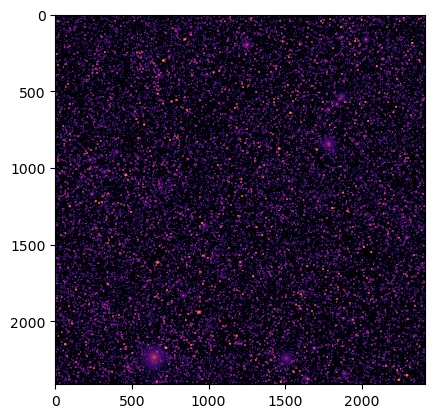

In [9]:
##Plot Image (optional)
import matplotlib as mpl
array = raw
norm = mpl.colors.SymLogNorm(linthresh=0.005, vmin=array.min(), vmax=array.max())
plt.imshow(array, norm=norm, cmap='inferno')


In [10]:
#Loop to generate multiple ones and save as a h5 file: 
# Load RA and DEC
dataTab = cTab
ra = dataTab['ra']
dec = dataTab['dec']
flux_column = dataTab['flux_z']

#Define Offsets (else random)
#ra_offset = 270
#dec_offset = 66


# Compute min and max values
ra_min, ra_max = np.min(ra), np.max(ra)
dec_min, dec_max = np.min(dec), np.max(dec)

# Shrink the range by 3 degrees from both ends
ra_min_shrunk = ra_min + 3
ra_max_shrunk = ra_max - 3

dec_min_shrunk = dec_min + 3
dec_max_shrunk = dec_max - 3

ra_offset = np.random.randint(ra_min_shrunk, ra_max_shrunk + 1) 
dec_offset = np.random.randint(dec_min_shrunk, dec_max_shrunk + 1)

num_images = 10 
raw_outputs = []

for i in range(num_images):
    ra_offset = np.random.randint(ra_min_shrunk, ra_max_shrunk + 1) 
    dec_offset = np.random.randint(dec_min_shrunk, dec_max_shrunk + 1)
    raw = SPHEREx.parallel_canvas_generator(ra, 
                                            dec,
                                            flux_column, 
                                            ra_offset = ra_offset,
                                            dec_offset = dec_offset, 
                                            dataTable = dataTab, 
                                            reso_ratio = reso_ratio,
                                            psf_length = psf_length,
                                            n_spherex_pix=64, 
                                            n_sections=4)
    print (f'Image {i} generated')
    raw_outputs.append(raw)

Edge Sersics Progress:: 100%|██████████| 31/31 [00:01<00:00, 28.58it/s]


Image 0 generated


Edge Sersics Progress:: 100%|██████████| 33/33 [00:01<00:00, 29.41it/s]


Image 1 generated


Edge Sersics Progress:: 100%|██████████| 43/43 [00:01<00:00, 30.19it/s]


Image 2 generated


Edge Sersics Progress:: 100%|██████████| 39/39 [00:01<00:00, 30.31it/s]


Image 3 generated


Edge Sersics Progress:: 100%|██████████| 38/38 [00:01<00:00, 30.43it/s]


Image 4 generated


Edge Sersics Progress:: 100%|██████████| 35/35 [00:01<00:00, 29.27it/s]


Image 5 generated


Edge Sersics Progress:: 100%|██████████| 30/30 [00:00<00:00, 30.24it/s]


Image 6 generated


Edge Sersics Progress:: 100%|██████████| 35/35 [00:01<00:00, 30.32it/s]


Image 7 generated


Edge Sersics Progress:: 100%|██████████| 23/23 [00:00<00:00, 29.67it/s]


Image 8 generated


Edge Sersics Progress:: 100%|██████████| 40/40 [00:01<00:00, 30.22it/s]

Image 9 generated


In [11]:

def processImg(raw_image, psf_file='SPHEREx/psf_data/simulated_PSF_2DGaussian_1perarray.fits', psf_length=54,target_resolution=3.1):
    """
    Processes an image for SPHEREx by convolving it with a PSF and binning the result.


    """
    # Open the FITS file and extract PSF data
    hdul = fits.open(psf_file)
    hdu_psf = hdul[42]
    reso_ratio = int(target_resolution/ hdu_psf.header['HIERARCH platescale'])
    psf = hdu_psf.data
    hdul.close()

    # Crop and normalize the PSF
    c = int(psf.shape[0] / 2)
    psf = psf[c - psf_length:c + psf_length, c - psf_length:c + psf_length]
    psf = psf / np.sum(psf)

    # Convolve raw image with PSF
    convolved = correlate(raw_image, psf, mode='valid')

    # Bin the image
    def bin2d(img, ratio):
        m_bins = img.shape[0] // ratio
        n_bins = img.shape[1] // ratio
        img_binned = img.reshape(m_bins, ratio, n_bins, ratio).sum(3).sum(1)
        img_binned /= ratio**2
        return img_binned

    binned = bin2d(convolved, reso_ratio)

    return convolved, binned


In [12]:
from scipy.signal import correlate
convolved,binned = processImg(raw_outputs[0],target_resolution=6.2)

In [13]:
raw_outputs[0].shape, convolved.shape, binned.shape

((1259, 1259), (1152, 1152), (64, 64))

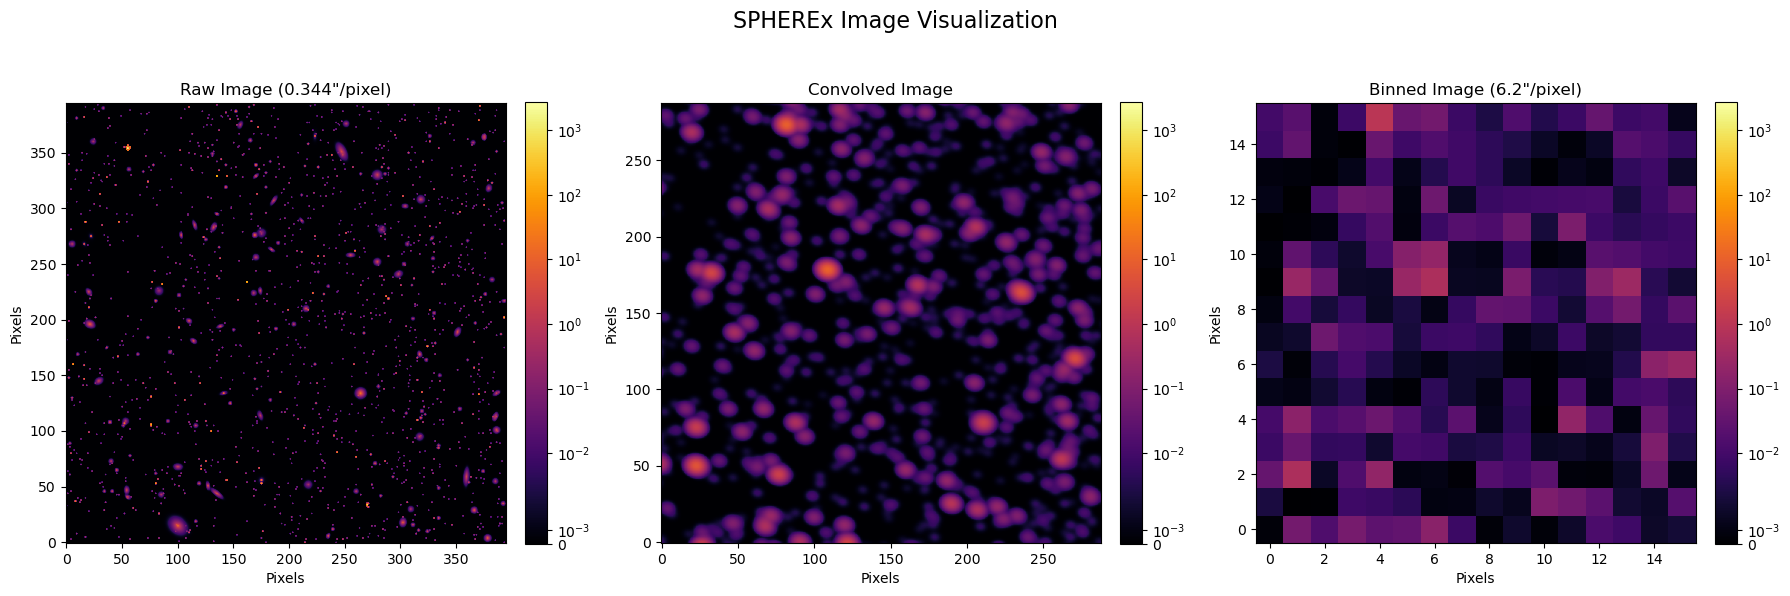

In [25]:
#SPHEREx.plotImg(raw_outputs[0],convolved,binned)
import matplotlib as mpl

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
norm = mpl.colors.SymLogNorm(linthresh=0.005)

titles = ['Raw Image (0.344"/pixel)', 'Convolved Image', 'Binned Image (6.2"/pixel)']
images = [raw_outputs[0], convolved, binned]

for ax, img, title in zip(axes, images, titles):
    im = ax.imshow(img, norm=norm, cmap='inferno', origin='lower')
    ax.set_title(title)
    ax.set_xlabel('Pixels')
    ax.set_ylabel('Pixels')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

fig.suptitle('SPHEREx Image Visualization', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [14]:
import h5py
output_filename = "/home/marco/SPHEREx-ML/largeOutputs/simulated64pixBackgrounds.h5"
with h5py.File(output_filename, "w") as hdf:
    hdf.create_dataset("raw_outputs", data=raw_outputs)

### Open h5 file to check if stuff actually saved right

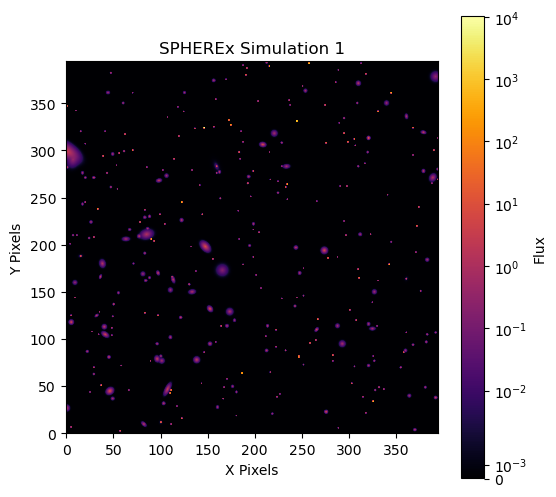

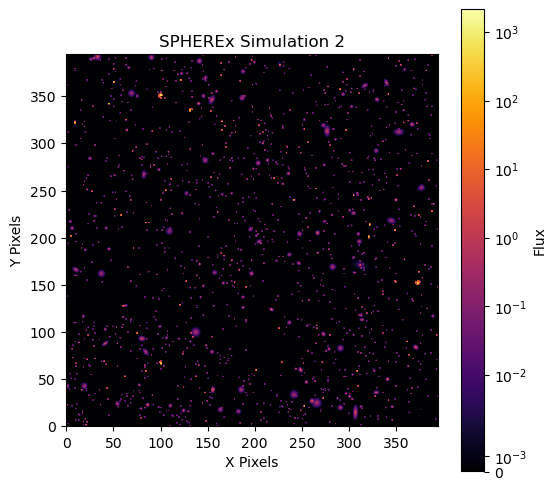

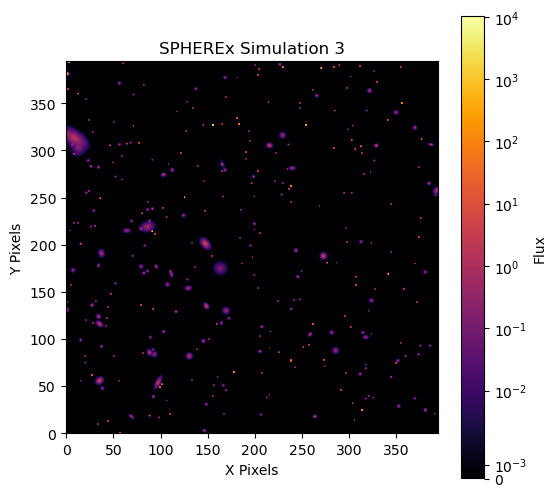

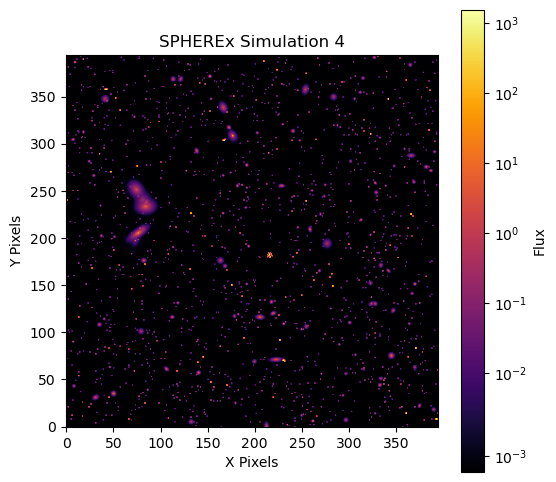

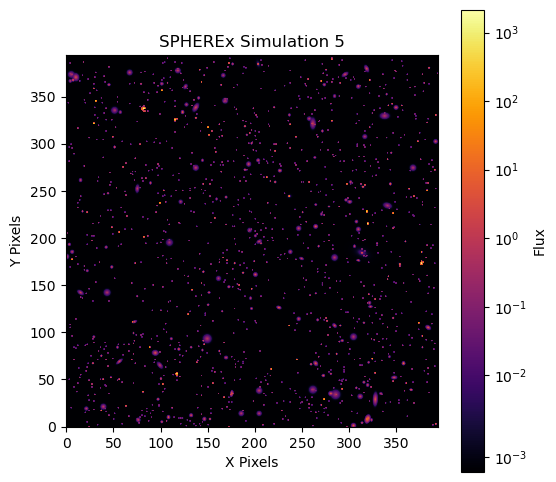

In [17]:
import matplotlib as mpl

with h5py.File("output/simulated32size.h5", "r") as hdf:
    loaded_data = hdf["raw_outputs"][:]



for i, data in enumerate(loaded_data):
    norm = mpl.colors.SymLogNorm(linthresh=0.005)
    plt.figure(figsize=(6, 6))
    plt.imshow(data, cmap='inferno', origin='lower',norm=norm)
    plt.colorbar(label="Flux")
    plt.title(f"SPHEREx Simulation {i+1}")
    plt.xlabel("X Pixels")
    plt.ylabel("Y Pixels")
    plt.show()

In [29]:
convolved, binned = SPHEREx.processImg(raw)


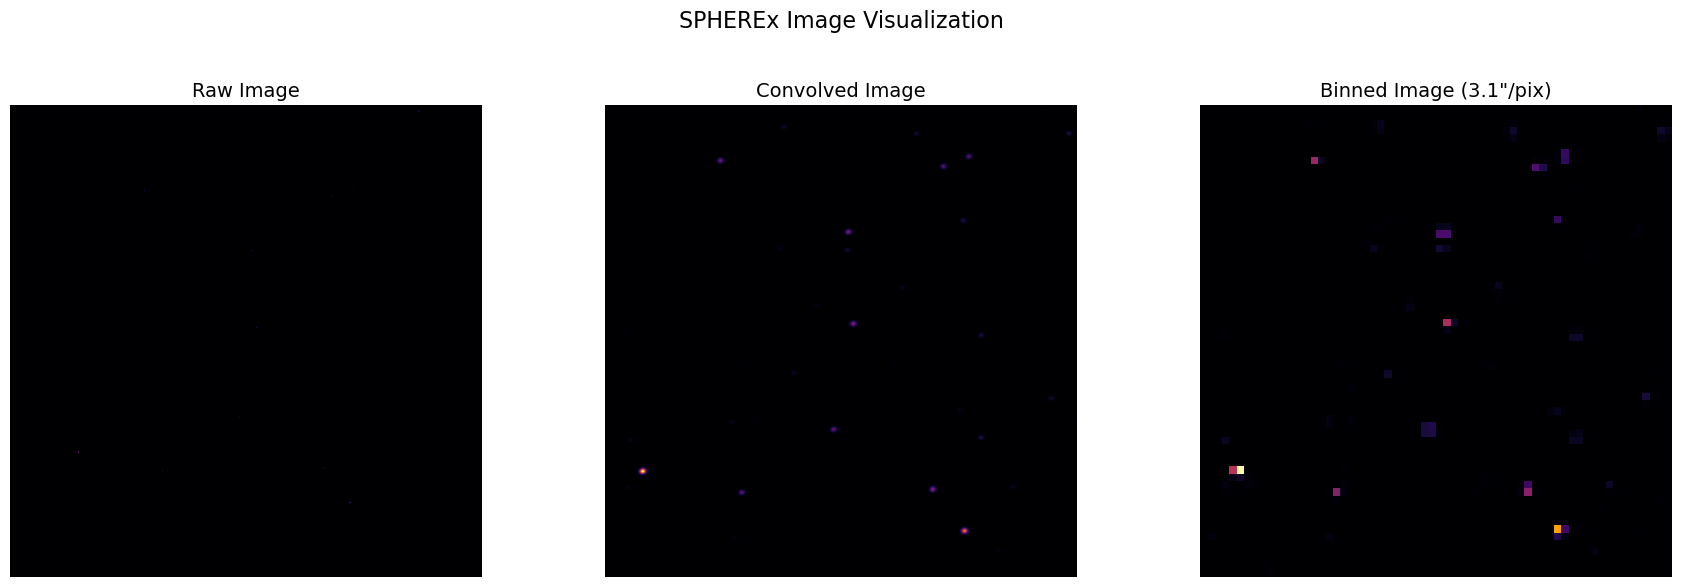

In [24]:
SPHEREx.plotImg(raw_image=raw,convolved=convolved,binned=binned)

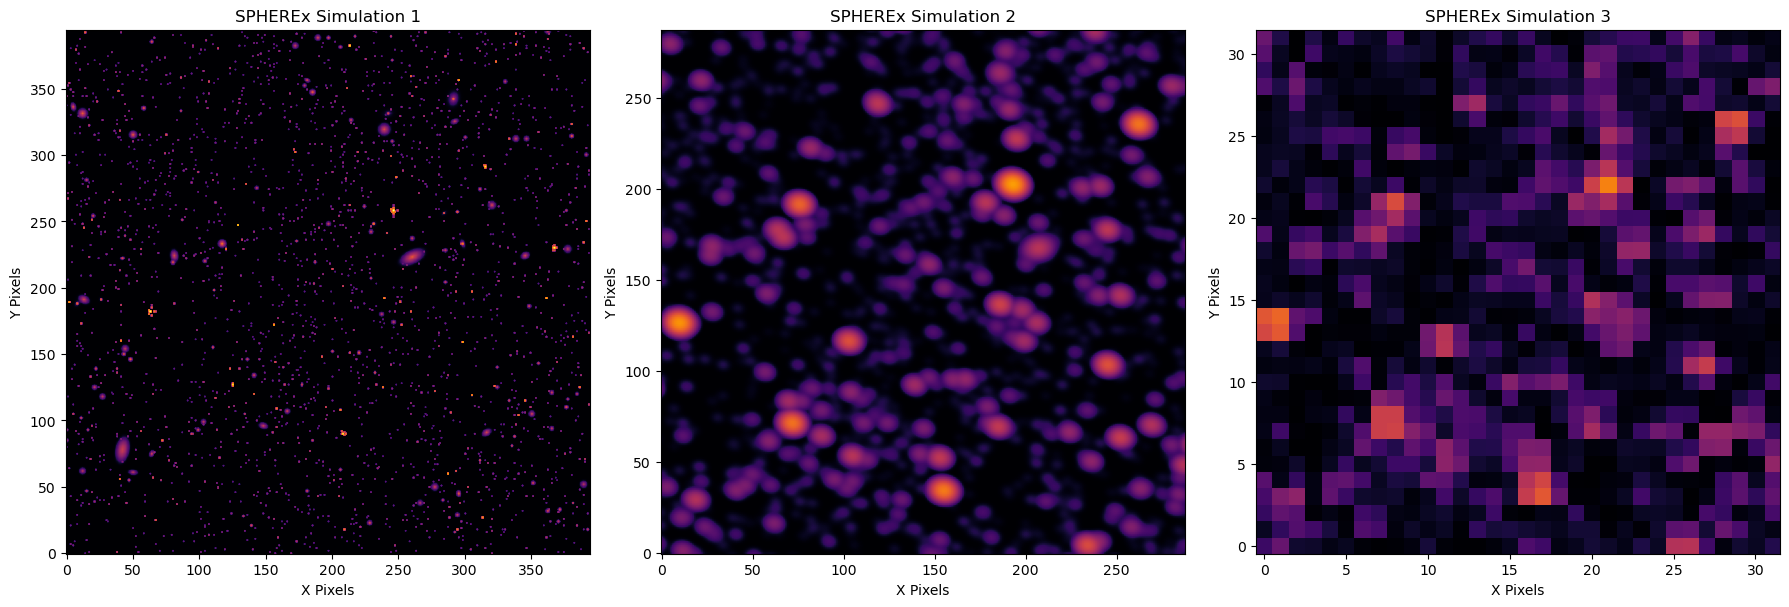

In [30]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# Example data (replace with your actual images)
data1, data2, data3 = raw, convolved,binned  # Replace with actual image data

norm = mpl.colors.SymLogNorm(linthresh=0.005)

# Create a figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1 row, 3 columns

# List of data and titles
data_list = [data1, data2, data3]
titles = ["SPHEREx Simulation 1", "SPHEREx Simulation 2", "SPHEREx Simulation 3"]

for i, ax in enumerate(axes):
    im = ax.imshow(data_list[i], cmap='inferno', origin='lower', norm=norm)
    ax.set_title(titles[i])
    ax.set_xlabel("X Pixels")
    ax.set_ylabel("Y Pixels")

# Add a single colorbar for all subplots
#fig.colorbar(im, ax=axes.ravel().tolist(), label="Flux")

plt.tight_layout()
plt.show()